### Pdf to List of Images Conversion

In [ ]:
!pip install wand
!pip install pytesseract opencv-python

In [27]:

from __future__ import print_function
from wand.image import Image as wi
import os; from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import time


In [28]:
cwd = os.getcwd()
#cwd = cwd[0:len(cwd)-cwd[::-1].index('\\')] # List comprehension ! 
filepath = "icdoc.pdf"

### Convert file to Jpeg
* pdf.sequence -> Gives you the number of pages
* Conversion of images to Jpeg (Complete PDF sequence to JPEG)

In [29]:
temp = time.time()
pdf = wi(filename = filepath, resolution=300, background = 'white') # Wand image , Resolution (300 ? DPI )
numPages = len(pdf.sequence)   #should be a class prop
pdfImages = pdf.convert("jpeg") # Jpeg Converstion 
print("The time Consumed : ", time.time() - temp) # Conversion of the Jpeg

The time Consumed :  11.477209329605103


In [30]:
pageImages = []   #should be a class prop
for img in pdfImages.sequence: # goes through every page of the PDF images ! 
    page = wi(img) # passes it back to wand (PDF --> Wand --> PIL ---( blob. io ! ))
    PIL_img = Image.open(BytesIO(page.make_blob('jpeg'))) # Bytes mapping ! 
    pageImages.append(PIL_img) # Adding the PIL object ! 

In [31]:
len(pageImages)

10

c:\users\shafay.amjad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The 'shape' parameter of imshow() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'shape', they should be pass as keyword, not positionally.
  """Entry point for launching an IPython kernel.


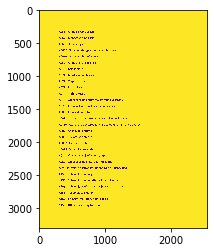

In [32]:
plt.imshow(pageImages[2], shape = (100,8))

### Noise Calculation (page based)
* Page Based
* English Grammer Mapping ( Either by Engish Dictionary or any other module)


In [33]:
import pytesseract
import pandas as pd
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from threading import Thread
import concurrent.futures

%matplotlib inline

In [34]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

### Get Blocks

In [35]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

### Using Py Tesseract

In [36]:
def get_noise_val_Image(imagePIL, NoiseThreshold_ppage): # NoiseThreshold_ppage is b/w 0 and 1
    '''
    Params:
        imagePIL - PIL image object
        NoiseThreshold_ppage - %age noise threshold for an image range [0, 1]
        
    Returns:
        ratio of dark pixels and total pixels
        boolean page acceptance result based on noise ratio
        binary image with 0 representing noise pixels    
    '''
    
    BinaryThreshold = 195          #will come from config file
    
    
    # matcopy = imagePIL.copy()
    grayPIL = imagePIL.convert('LA') # Grey scale Conversion
    imageNUMPY = np.array(grayPIL, dtype='uint8') # integer8 (Gray Image converssion ! )
    
    Tessstart = time.time()
    data_result = pytesseract.image_to_data(imagePIL, lang='eng') # Langugae AuTODETECTION ??????? 
    # By default we are considering the English langauge 
    print("Tess EndTime taken", time.time() - Tessstart) # Time Bench marks 
    
    data_lines = ([s_inner.split() for s_inner in data_result.splitlines()]) # Data lines ( )
    df = pd.DataFrame(data_lines[1:], columns = data_lines[0])
    df = df.dropna() # Null vaulues removal as those would be empty
    
    
    # DFFORstart = time.time()
    for index, row in df.iterrows():
        r = int(row['top']); r_ = r + int(row['height'])
        c = int(row['left']); c_ = c + int(row['width'])
        imageNUMPY[r:r_, c:c_, :] = 255
    # print("DFFOR EndTime taken", time.time() - DFFORstart)
    
    #bin_ = rgb2gray(imageNUMPY)
    bin_ = np.zeros(imageNUMPY.shape)
    
    bin_ = np.where(bin_ > BinaryThreshold, 1, 0)
    
    pixels_num = bin_.shape[0]*bin_.shape[1]
    ratio = (pixels_num - bin_.sum())/pixels_num
    # Noise Ration (pivoted), Rejected or Accepted , Binary Image 
    return ratio, ratio > NoiseThreshold_ppage, bin_ #returns the ratio, rejection result, binary_Image

In [37]:
def get_noise_params_PDF(PDFImages, NoiseThreshold_ppage  = 0.50):
    ''' IN-PROGRESS
    PDFImages: r x c x ch x num where num is number of 
    '''
    PAGESCOUNT = len(PDFImages)
    pageNoiseFlag = [0]*PAGESCOUNT   #should be a class prop

    FORstart = time.time()
    
    for i in range(0, len(PDFImages)):
        if(get_noise_val_Image(PDFImages[i], NoiseThreshold_ppage)[1]): #rejection means: page is noisy
            pageNoiseFlag[i] = 1
    
    print("FOR EndTime taken", time.time() - FORstart)
    
    return   sum(pageNoiseFlag)/PAGESCOUNT, pageNoiseFlag #returns the %age of pages that are noisy [0, 1]

In [38]:
### Using the functions

# R, r, I = get_noise_val_Image(imageMAT, 0.50)

# print(R, r)

# plt.imshow(I)
# plt.show()

In [39]:
start = time.time()
res = get_noise_params_PDF(pageImages)
print("Time taken", time.time() - start)

Tess EndTime taken 3.086804151535034
Tess EndTime taken 3.077725887298584
Tess EndTime taken 3.015650510787964
Tess EndTime taken 4.341964244842529
Tess EndTime taken 2.9549496173858643
Tess EndTime taken 2.400911331176758
Tess EndTime taken 3.271383762359619
Tess EndTime taken 3.786754846572876
Tess EndTime taken 3.318714141845703
Tess EndTime taken 3.9392547607421875
FOR EndTime taken 37.924375772476196
Time taken 37.92633819580078


In [40]:
start = time.time()
res = get_noise_val_Image(pageImages[1], 0.50)[1]
print("Time taken", time.time() - start)

Tess EndTime taken 3.0492091178894043
Time taken 3.531099796295166


### OCR SCAN
* Images to Text Conversion 
* Table Detection (Table detection does happens in the java code but doesn't go in the grain)
     * TH , TR , TD
* Background Detection
    * Specific Line Background
    * Word Level, Block Level & Line Level (Under Progress)
    
* Font Characterstics
    * Font Density ( Tried to do in jar but was inefficent, insufficent and inaccurate)
        * Bold 
        * Light
    * Font Size
* Hand Written Detection (ITS UNDER PROGRESS)
    * HandWritten Model vs Digital Text Model
    * Evaluation of Metrices
    
     
      

In [41]:
# from PIL import Image
# import pytesseract

# try:
#     img = Image.open(path/to/image.png) 
#     pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'
#     text = pytesseract.image_to_string(path/to/image.png)
#     print(text)

In [42]:
"C:\Program Files\Tesseract-OCR\tesseract.exe"

'C:\\Program Files\\Tesseract-OCR\tesseract.exe'

In [43]:
#import pytesseract

In [44]:
#!pip install pillow
IMAGEPATH = 'tb-doc-1.jpg'

In [45]:
def draw_rects(img, x,y,x2,y2, block_type, conf):
    """
   ?????????????
   :param img:
   :param rects:
   :return:
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(img, (x, y), (x2, y2), (0, 0, 255), 2)
    cv2.imshow('Image',img)
    cv2.waitKey(5)
   #cv2.imwrite("image" + str(block_type) + ".jpg", img)
   #plt.imsave('./final_image.jpg',img)
    cv2.putText(img, str(conf), (x, y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

In [46]:
from tesserocr import PyTessBaseAPI
import cv2
from tesserocr import PyTessBaseAPI, PSM, PT, RIL, iterate_level
from PIL import Image
import time

In [47]:
pytestapi_path = r"C:\Program Files\Tesseract-OCR\tessdata"

In [58]:
with PyTessBaseAPI(path=pytestapi_path) as api:
    api.SetImageFile(IMAGEPATH)
    api.Recognize()
    image = Image.open(IMAGEPATH)
    image_np = np.array(image)
    ri = api.GetIterator()
    level = RIL.BLOCK # Block based Values 
    
    # Table is detectable ( we can get the verticle and horizental Lins )
    for r in iterate_level(ri, level):
        symbol = r.GetUTF8Text(level)  # r == ri   Text data of that specific block 
        conf = r.Confidence(level) # Confidence level of that text 
        block_type = r.BlockType() # Type of that specific blocl
        bounding_box_cord = r.BoundingBox(level) # Bounding box around that specific text 
        print(block_type, bounding_box_cord, conf) #  BBox output for current block
        left = bounding_box_cord[0]
        top = bounding_box_cord[1]
        right = bounding_box_cord[2]
        bottom = bounding_box_cord[3]
        #if (block_type == PT.TABLE):
        draw_rects(image_np,left,top,right,bottom, block_type, conf)         # Drawing those boxes inline image 

cv2.waitKey(0)
cv2.destroyAllWindows()

1 (324, 218, 1295, 305) 96.34042358398438
1 (379, 490, 1172, 548) 94.70921325683594
1 (376, 615, 2125, 734) 95.21932983398438
1 (935, 1247, 1345, 1515) 26.00366973876953
1 (858, 1601, 1702, 1701) 92.1291275024414
1 (855, 1701, 1701, 1756) 92.93549346923828
8 (872, 1213, 929, 1444) 14.228012084960938
9 (862, 804, 1680, 1526) 95.0
1 (375, 1837, 2145, 2093) 96.08604431152344
1 (384, 2146, 1776, 2664) 86.960205078125
1 (376, 2725, 2148, 2843) 96.00785827636719
1 (826, 2984, 1722, 3023) 95.30288696289062
1 (378, 2862, 710, 2912) 96.18319702148438
1 (35, 3215, 204, 3262) 95.77655029296875


### Background Detection / Evaluation

In [49]:
#   from __future__ import print_function

from tesserocr import PyTessBaseAPI, PSM, PT, RIL, iterate_level
from PIL import Image
import time
import cv2
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [50]:
!python --version

Python 3.7.4


In [51]:
IMAGEPATH = 'out10.jpg'
PILimage = Image.open(IMAGEPATH)
NUMPYimage = np.array(PILimage, dtype='int16')
print(NUMPYimage.shape, NUMPYimage.dtype)

(3300, 2550, 3) int16


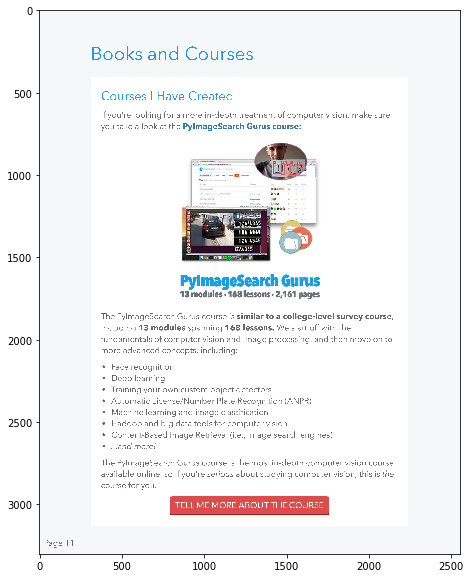

In [52]:
plt.figure(figsize=(20, 10))
plt.imshow(NUMPYimage)
plt.show()

In [54]:
with PyTessBaseAPI(path = pytestapi_path) as api:
    numBIN = 20
    api.SetImage(PILimage)
    api.Recognize()
    
    
    
    ri = api.GetIterator()
    level = RIL.WORD
    # Word by word iterator 
    for r in iterate_level(ri, level):
        if r:
            bbox = r.BoundingBox(level)
            #print(bbox)
            if bbox: ## Now black (-1) 'em out
                # Word_BBoxes.append(bbox)
                # print(bbox)
                NUMPYimage[bbox[1]:bbox[3], bbox[0]:bbox[2], :] = -1
    
    ri = api.GetIterator()
    level = RIL.TEXTLINE
    # Text line iterator ! 
    Line_BBoxes = []
    for r in iterate_level(ri, level):
        if r:
            bbox = r.BoundingBox(level)
            if bbox:
                # Line_BBoxes.append(bbox)
                x1, y1, x2, y2 = bbox
                
                colorbin = np.ones((numBIN, 3), dtype = 'int16') *-1
                
                combs = np.where(NUMPYimage[y1:y2, x1:x2, 0] != -1) # Check if the image didn't had the -1 there
                if (combs[0].size != 0): # check if the size is not zero 
                    bin_i = 0
                    # Choose randomly bins (20 is the default set right now )
                    # To check the image or the bin or whatsoever 
                    for i in np.random.choice(range(combs[0].shape[0]), numBIN):
                        x = combs[1][i]
                        y = combs[0][i]
                        colorbin[bin_i] = NUMPYimage[y1+y, x1+x, :]
                        bin_i += 1
                    # Historgram 

                    hist = {}
                    for r, g, b in colorbin:
                        if not (r == -1):
                            RGB = str(r)+"_"+str(g)+"_"+str(b)
                            if RGB in list(hist.keys()):
                                hist[RGB] += 1
                            else:
                                hist[RGB] = 1
                    if len(list(hist.keys())):
                        print(x1, x2, y1, y2)
                        print("------------",list(hist.keys())[list(hist.values()).index(max(list(hist.values())))].split("_"))


324 1295 218 305
------------ ['246', '247', '249']
379 1172 490 548
------------ ['255', '255', '255']
379 2125 615 665
------------ ['255', '255', '255']
376 1587 684 734
------------ ['255', '255', '255']
858 1702 1600 1701
------------ ['255', '255', '255']
855 1699 1701 1756
------------ ['255', '255', '255']
376 2145 1837 1887
------------ ['255', '255', '255']
379 1887 1906 1956
------------ ['255', '255', '255']
375 2139 1975 2025
------------ ['255', '255', '255']
379 1201 2043 2093
------------ ['255', '255', '255']
384 814 2146 2193
------------ ['255', '255', '255']
384 761 2212 2262
------------ ['255', '255', '255']
384 1407 2281 2331
------------ ['255', '255', '255']
384 1648 2350 2400
------------ ['255', '255', '255']
384 1385 2418 2468
------------ ['255', '255', '255']
384 1502 2487 2537
------------ ['255', '255', '255']
384 1776 2556 2606
------------ ['255', '255', '255']
384 706 2625 2664
------------ ['255', '255', '255']
376 2147 2725 2775
------------ ['255',

### Font Characterstics


In [55]:
from __future__ import print_function

from tesserocr import PyTessBaseAPI, PSM, PT, RIL, iterate_level
from PIL import Image
import time
import cv2
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [56]:
def get_font(image_path):
    IMAGEPATH = image_path
    original_image =Image.open(image_path)
    with PyTessBaseAPI(path=pytestapi_path) as api:
        api.SetImageFile(IMAGEPATH)
        api.Recognize()
        
        ri = api.GetIterator()
        level = RIL.SYMBOL # sYMBOL ! 
        print(type(ri))
        
        for r in iterate_level(ri, level):
            if r:
                #print(r)
                symbol = r.GetUTF8Text(level) # Text extraction 
                img = r.GetBinaryImage(level) # Binary image conversion as per level
                
                img_sh = np.asarray(img)
                denom = img_sh.size

                # Pixel Density -> 1 - Sum of bounding box iamge / (size of array * 255)
                pixel_density = 1- (img_sh.sum()/(denom*255))
                print(symbol, pixel_density)

In [57]:
get_font("out10.jpg")

<class 'tesserocr._tesserocr.PyResultIterator'>
B 0.46369747899159663
o 0.34280036338859865
o 0.33958737341090284
k 0.4484181908057341
s 0.21927707783777262
a 0.4597884729649435
n 0.4099286413438161
d 0.3222349253180896
C 0.2641694975862685
o 0.184233426704015
u 0.346750700280112
r 0.33897547623037816
s 0.3586540789155168
e 0.4211119230300816
s 0.350484360410831
C 0.2640607758254817
o 0.18574696545284786
u 0.3692951775304717
r 0.31970769789397235
s 0.33806654952165793
e 0.444912559618442
s 0.3476967918144389
| 1.0
H 0.3650314465408805
a 0.4506094329623741
v 0.3105091448344044
e 0.4325010131238505
C 0.25390314020344984
r 0.4919934640522876
e 0.44354531001589825
a 0.39756815639168586
t 0.38439897698209724
e 0.43381759040988255
d 0.33655866820167024
I 0.7769467787114845
f 0.2894599243206054
y 0.26344283167812577
o 0.3159764705882353
u 0.35205610021786493
' 0.4476919934640523
r 0.1628622358034123
e 0.41947144075021314
l 0.750515995872033
o 0.3192734778121775
o 0.314344685242518
k 0.4666143

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'